In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ASUS\Anaconda3\envs\tensorflow-gpu\lib\s

In [2]:
from __future__ import print_function
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator


# 挤压函数
# 我们在此使用 0.5，而不是 Hinton 论文中给出的 1
# 如果为 1，则向量的范数将被缩小。
# 如果为 0.5，则当原始范数小于 0.5 时，范数将被放大，
# 当原始范数大于 0.5 时，范数将被缩小。
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# 使用自定义的 softmax 函数，而非 K.softmax，
# 因为 K.softmax 不能指定轴。
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# 定义 margin loss，类似于 hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(Layer):
    """一个由纯 Keras 实现的 Capsule 网络。
    总共有两个版本的 Capsule。
    一个类似于全连接层 (用于固定尺寸的输入)，
    另一个类似于时序分布全连接层 (用于变成输入)。

    Capsure 的输入尺寸必须为 (batch_size,
                             input_num_capsule,
                             input_dim_capsule
                            )
    以及输出尺寸必须为 (batch_size,
                      num_capsule,
                      dim_capsule
                     )

    Capsule 实现来自于 https://github.com/bojone/Capsule/
    Capsule 论文: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """遵循 Hinton 论文中的路由算法，
        但是将 b = b + <u,v> 替换为 b = <u,v>。

        这一改变将提升 Capsule 的特征表示能力。

        然而，你仍可以将
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        替换为
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        来实现一个标准的路由。
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


batch_size = 128
num_classes = 10
epochs = 25
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

# 一个常规的 Conv2D 模型
input_image = Input(shape=(None, None, 3))
x = Conv2D(64, (3, 3), activation='relu')(input_image)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = AveragePooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = Conv2D(128, (3, 3), activation='relu')(x)


"""现在我们将其尺寸重新调整为 (batch_size, input_num_capsule, input_dim_capsule)，再连接一个 Capsule 网络。

最终模型的输出为长度为 10 的 Capsure，其 dim=16。

Capsule 的长度表示为 proba，
因此问题变成了一个『10个二分类』的问题。
"""

x = Reshape((-1, 128))(x)
capsule = Capsule(10, 16, 3, True)(x)
output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

# 使用 margin loss
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
model.summary()

# 可以比较有无数据增益对应的性能
data_augmentation = False

if not data_augmentation:
    print('Not using data augmentation.')
    train_history=model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # 这一步将进行数据处理和实时数据增益:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # 将整个数据集的均值设为 0
        samplewise_center=False,  # 将每个样本的均值设为 0
        featurewise_std_normalization=False,  # 将输入除以整个数据集的标准差
        samplewise_std_normalization=False,  # 将输入除以其标准差
        zca_whitening=False,  # 运用 ZCA 白化
        zca_epsilon=1e-06,  # ZCA 白化的 epsilon值
        rotation_range=0,  # 随机旋转图像范围 (角度, 0 to 180)
        width_shift_range=0.1,  # 随机水平移动图像 (总宽度的百分比)
        height_shift_range=0.1,  # 随机垂直移动图像 (总高度的百分比)
        shear_range=0.,  # 设置随机裁剪范围
        zoom_range=0.,  # 设置随机放大范围
        channel_shift_range=0.,  # 设置随机通道切换的范围
        # 设置填充输入边界之外的点的模式
        fill_mode='nearest',
        cval=0.,  # 在 fill_mode = "constant" 时使用的值
        horizontal_flip=True,  # 随机水平翻转图像
        vertical_flip=False,  # 随机垂直翻转图像
        # 设置缩放因子 (在其他转换之前使用)
        rescale=None,
        # 设置将应用于每一个输入的函数
        preprocessing_function=None,
        # 图像数据格式，"channels_first" 或 "channels_last" 之一
        data_format=None,
        # 保留用于验证的图像比例（严格在0和1之间）
        validation_split=0.0)

    # 计算特征标准化所需的计算量
    # (如果应用 ZCA 白化，则为 std，mean和主成分)。
    datagen.fit(x_train)

    # 利用由 datagen.flow() 生成的批来训练模型。
    train_history=model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        steps_per_epoch=len(x_train)/batch_size,
        validation_data=(x_test, y_test),
        workers=4)


Using TensorFlow backend.







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
average_pooling2d_1 (Average (None, None, None, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
reshape_1 (Reshape)          (None, None, 128)         0         
_____

In [3]:
import matplotlib.pyplot as plt
def show_train_history(train_acc,test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

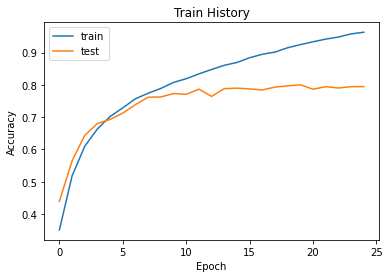

In [4]:
show_train_history('acc','val_acc')

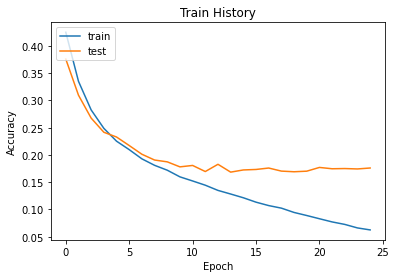

In [5]:
show_train_history('loss','val_loss')

In [6]:
scores = model.evaluate(x_test, y_test)
scores[1]

10000/10000 [==============================] - 1s 116us/step


0.7945